In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import skorch

from denoising.autoencoder import Encoder

from yahoo_fin_api import load_df

2023-02-24 23:18:29.184180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 23:18:29.845959: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-24 23:18:29.846041: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-24 23:18:29.846047: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [57]:
df = load_df('data/snp.csv')[['Open', 'High', 'Low', 'Close']]
df.head(), len(df)

,Open,High,Low,Close
Date,,,,
1990-02-26,324.160004,328.670013,323.980011,328.670013
1990-02-27,328.679993,331.940002,328.470001,330.260010
1990-02-28,330.260010,333.480011,330.160004,331.890015
1990-03-01,331.890015,334.399994,331.079987,332.739990
1990-03-02,332.739990,335.540009,332.720001,335.540009


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

In [76]:
# Random seed to make results deterministic and reproducible

torch.manual_seed(0)

# Do not use in DNN-AE

# make dataset to input
class StockDataset(Dataset):
    def __init__(self, data):
        self.data = data.values.astype('float32')  # convert data to numpy array of type float32
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index, :4]  # select the first three columns as input
        y = self.data[index, :4]   # select the fourth column as output
        return x, y

dataset = StockDataset(df)

batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.encoder = nn.Sequential(
      nn.Linear(4, 8),
      nn.ReLU(),
      nn.Linear(8, 8),
      nn.ReLU(),
      nn.Linear(8, 6),
      nn.ReLU(),
      nn.Linear(6, 2),
      nn.ReLU()
    )

    self.decoder = nn.Sequential(
      nn.Linear(2, 6),
      nn.ReLU(),
      nn.Linear(6, 8),
      nn.ReLU(),
      nn.Linear(8, 8),
      nn.ReLU(),
      nn.Linear(8, 4),
      nn.ReLU()
    )
    
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    
    return decoded


model = Net().to('cuda')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay=1e-5)

num_epoch = 200
for epoch in range(num_epoch):
  for X, y in dataloader: 
    total_loss = 0
    d = []
    X = X.to('cuda')
    y = y.to('cuda')

    optimizer.zero_grad()
    output = model(X)

    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    total_loss += loss.data.item()
  if epoch % 100 == 0:
    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epoch, loss/len(dataloader)))

Epoch [1/200], Loss: 896657.7500
Epoch [101/200], Loss: 249282.1250


In [77]:
tensor = torch.tensor(df.values, dtype=torch.float32).to('cuda')
tensor.shape

torch.Size([8313, 4])

In [80]:
with torch.no_grad():
    pred = model(tensor).to('cpu')
pred

tensor([[   0.0000,  329.9888,  327.4567,  327.3591],
        [   0.0000,  332.9228,  330.3702,  330.2722],
        [   0.0000,  334.5215,  331.9577,  331.8596],
        ...,
        [   0.0000, 4036.7222, 4008.2493, 4007.6494],
        [   0.0000, 4011.7446, 3983.4465, 3982.8496],
        [   0.0000, 4026.1697, 3997.7708, 3997.1721]])

In [83]:
df['Mean'] = df.mean(axis=1)
df['PredMean'] = pred.mean(axis=1)

<AxesSubplot: xlabel='Date'>

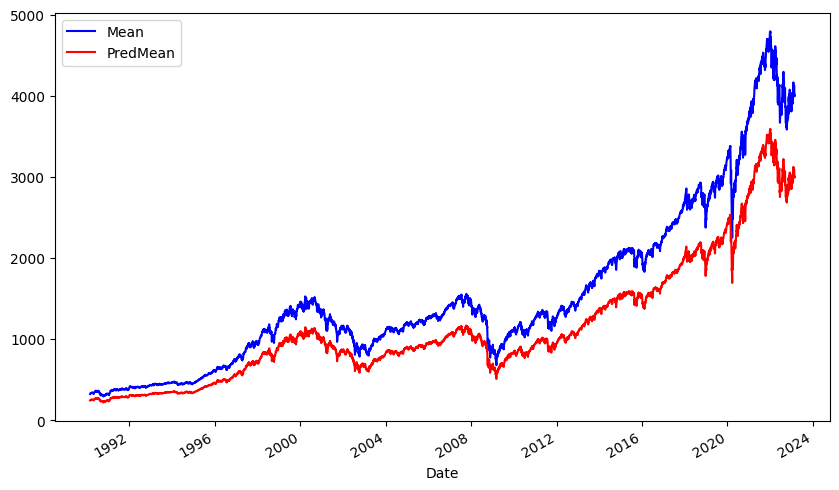

In [87]:
df[['Mean', 'PredMean']].plot(color=['b', 'r'], figsize=(10, 6))

In [6]:
'''x_train_deep = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

input_window = Input(shape=(4,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)'''

ValueError: The `kernel_size` argument must be a tuple of 1 integers. Received: (3, 4)

In [6]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
)

Epoch 1/50


2023-02-24 20:49:36.822605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-02-24 20:49:38.139891: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


: 

: 